In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm



2025-12-06 17:40:54.328002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 17:40:54.356482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 17:40:54.997358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Create dataframes

In [3]:
TRAIN_DIR = "images/train"
TEST_DIR  = "images/test"

In [4]:
def createdataframe(dir_path):
    image_paths = []
    labels = []
    for label in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, label)
        if not os.path.isdir(class_dir):
            continue
        for imagename in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths, labels

train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)



fear completed
neutral completed
surprise completed
sad completed
disgust completed
angry completed
happy completed
fear completed
neutral completed
surprise completed
sad completed
disgust completed
angry completed
happy completed


# Feature extraction (normalize only once)

In [5]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale", target_size=(48, 48))
        img = img_to_array(img)              # shape (48,48,1)
        img = img / 255.0                    # normalize here only
        features.append(img)
    return np.array(features)

x_train = extract_features(train['image'])
x_test  = extract_features(test['image'])


  0%|          | 0/28821 [00:00<?, ?it/s]

  0%|          | 0/7066 [00:00<?, ?it/s]

# Encode labels


In [6]:
le = LabelEncoder()
le.fit(train['label'])

y_train_int = le.transform(train['label'])
y_test_int  = le.transform(test['label'])

y_train = to_categorical(y_train_int, num_classes=len(le.classes_))
y_test  = to_categorical(y_test_int,  num_classes=len(le.classes_))

print("Classes:", le.classes_)
print("Train distribution:", np.unique(y_train_int, return_counts=True))
print("Test distribution:", np.unique(y_test_int, return_counts=True))



Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Train distribution: (array([0, 1, 2, 3, 4, 5, 6]), array([3993,  436, 4103, 7164, 4982, 4938, 3205]))
Test distribution: (array([0, 1, 2, 3, 4, 5, 6]), array([ 960,  111, 1018, 1825, 1216, 1139,  797]))


# Model definition

In [7]:
model = Sequential()
model.add(tf.keras.Input(shape=(48, 48, 1)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(len(le.classes_), activation='softmax'))

model.summary()


2025-12-06 17:42:59.002146: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-12-06 17:42:59.002159: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-12-06 17:42:59.002162: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-12-06 17:42:59.002164: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-06 17:42:59.002166: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: hp-HP-Z2-Tower-G9-Workstation-Desktop-PC
2025-12-06 17:42:59.002168: I external/local_xla/xla/stream_executor/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,335 (3.92 MB)

 Trainable params: 1,027,335 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

# Data augmentation (no extra rescaling)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


# Compile & train

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=80,
    validation_data=(x_test, y_test)
)


Epoch 1/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.2467 - loss: 1.8183 - val_accuracy: 0.2591 - val_loss: 1.7874
Epoch 2/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.2616 - loss: 1.7707 - val_accuracy: 0.3040 - val_loss: 1.6946
Epoch 3/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.3210 - loss: 1.6818 - val_accuracy: 0.4161 - val_loss: 1.5620
Epoch 4/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.3856 - loss: 1.5637 - val_accuracy: 0.4602 - val_loss: 1.3973
Epoch 5/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.4280 - loss: 1.4758 - val_accuracy: 0.4914 - val_loss: 1.3115
Epoch 6/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.4573 - loss: 1.4165 - val_accuracy: 0.5202 - val_loss: 1.2592
Epoch 7/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.4666 - loss: 1.3854 - val_accuracy: 0.5282 - val_loss: 1.2290
Epoch 8/80
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.4824 - loss: 1.3512 - 

# Proper predictions + metrics

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Unique predicted labels and counts:
{np.int64(0): np.int64(990), np.int64(1): np.int64(46), np.int64(2): np.int64(594), np.int64(3): np.int64(1877), np.int64(4): np.int64(1613), np.int64(5): np.int64(1147), np.int64(6): np.int64(799)}
Accuracy: 0.626379847155392

Classification Report:

              precision    recall  f1-score   support

       angry     0.5263    0.5427    0.5344       960
     disgust     0.6522    0.2703    0.3822       111
        fear     0.5219    0.3045    0.3846      1018
       happy     0.8215    0.8449    0.8331      1825
     neutral     0.5307    0.7039    0.6052      1216
         sad     0.4969    0.5004    0.4987      1139
    surprise     0.7472    0.7491    0.7481       797

    accuracy                         0.6264      7066
   macro avg     0.6138    0.5594    0.5695      7066
weighted avg     0.6248    0.6264    0.6181      7066



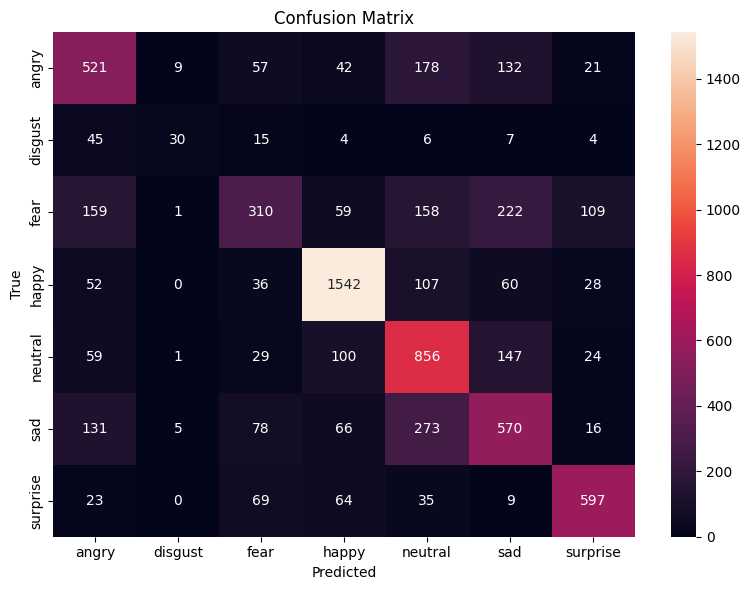

✓ Saved Confusion_matrix_INITIAL_TRAINING.png successfully!


In [36]:
# Predict on x_test directly
y_prob = model.predict(x_test)
y_pred_int = np.argmax(y_prob, axis=1)       # predicted class indices
y_test_int = np.argmax(y_test, axis=1)       # true class indices

print("Unique predicted labels and counts:")
unique, counts = np.unique(y_pred_int, return_counts=True)
print(dict(zip(unique, counts)))

# Accuracy
print("Accuracy:", accuracy_score(y_test_int, y_pred_int))

# Classification report with correct class names
print("\nClassification Report:\n")
print(classification_report(
    y_test_int,
    y_pred_int,
    target_names=le.classes_,    # match encoder
    digits=4
))

# Confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()                 # avoids cutting edges
plt.savefig("Confusion_matrix_INITIAL_TRAINING.png", dpi=300)   # save with high resolution
plt.show()
print("✓ Saved Confusion_matrix_INITIAL_TRAINING.png successfully!")

In [33]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test_int,
    y_pred_int,
    target_names=le.classes_,
    digits=4
)

with open("classification_report_INITIAL_TRAINING.txt", "w") as f:
    f.write(report)

print("✓ classification_report_INITIAL_TRAINING.txt saved!")

✓ classification_report_INITIAL_TRAINING.txt saved!


In [34]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_int, y_pred_int)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

cm_df.to_csv("confusion_matrix_INITIAL_TRAINING.csv", index=True)
print("✓ confusion_matrix_INITIAL_TRAINING.csv saved!")


✓ confusion_matrix_INITIAL_TRAINING.csv saved!


In [35]:
plt.savefig("Confusion_matrix_INITIAL_TRAINING.png")
print("Confusion_matrix_INITIAL_TRAINING.png saved!")

Confusion_matrix_INITIAL_TRAINING.png saved!


<Figure size 640x480 with 0 Axes>

# (Optional) Now fix the bias properly: add class weights

# Once the pipeline is correct, we can add class weights to fight the imbalance: do this in next target

# Save model for real-time use (JSON + H5)
This keeps compatibility with existing realtimedetection.py structure:

In [12]:
# Save architecture
model_json = model.to_json()
with open("initialfacialemotionmodel.json", "w") as json_file:
    json_file.write(model_json)

# Save weights
model.save_weights("initialfacialemotionmodel.weights.h5")
print("Saved model to initialfacialemotionmodel.json + initialfacialemotionmodel.weights.h5")

# now copy these new files into the same folder where realtimedetection.py expects them.

Saved model to initialfacialemotionmodel.json + initialfacialemotionmodel.weights.h5


In [14]:
model.save("initialfacialemotionmodel.keras")

# How to load it back later (JSON + weights style)

In [16]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("initialfacialemotionmodel.keras")

# Validation Of Model

In [17]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [19]:
def ef(image_path):
    # Load image as 48x48 grayscale
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    
    # Convert to array
    feature = img_to_array(img)           # shape: (48, 48, 1)
    
    # Normalize like during training
    feature = feature / 255.0
    
    # Add batch dimension: (1, 48, 48, 1)
    feature = feature.reshape(1, 48, 48, 1)
    
    return feature

In [25]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
model prediction is  sad


original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
model prediction is  sad


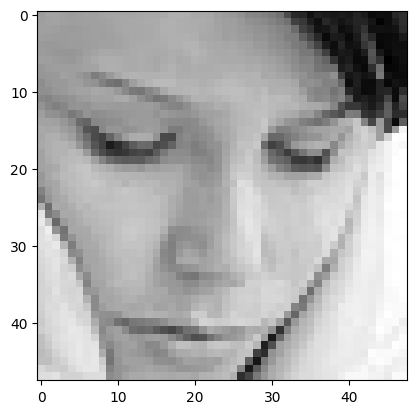

In [26]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
model prediction is  sad


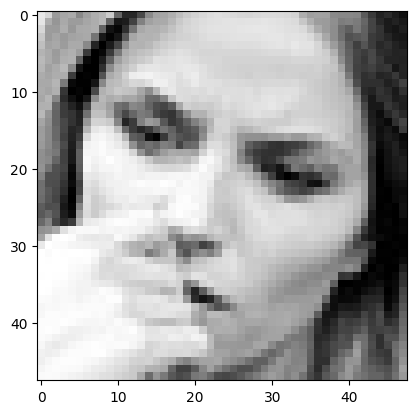

In [27]:
image = 'images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
model prediction is  angry


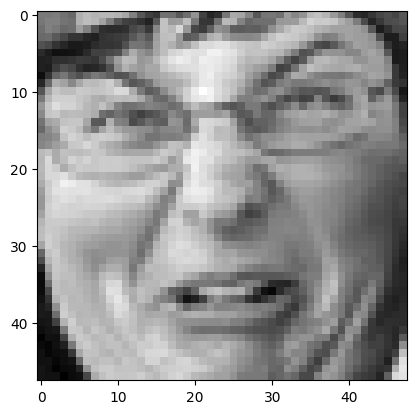

In [28]:
image = 'images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
model prediction is  happy


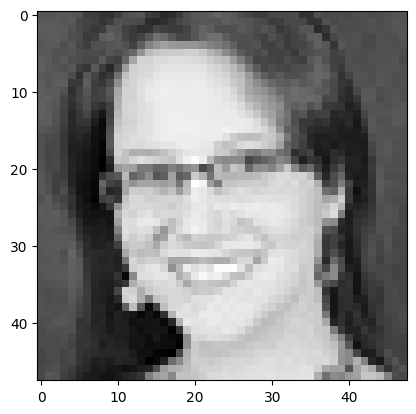

In [29]:
image = 'images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
model prediction is  surprise


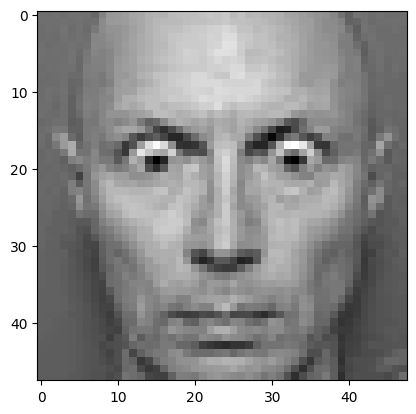

In [30]:
image = 'images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

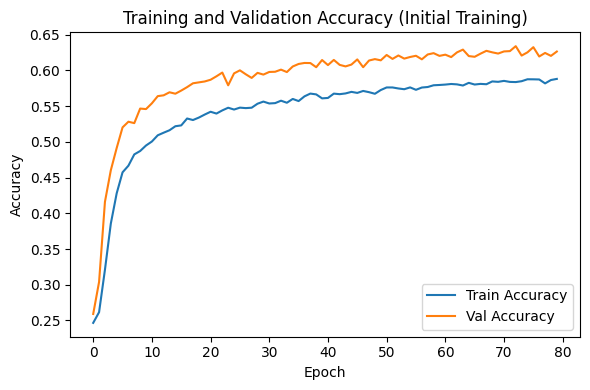

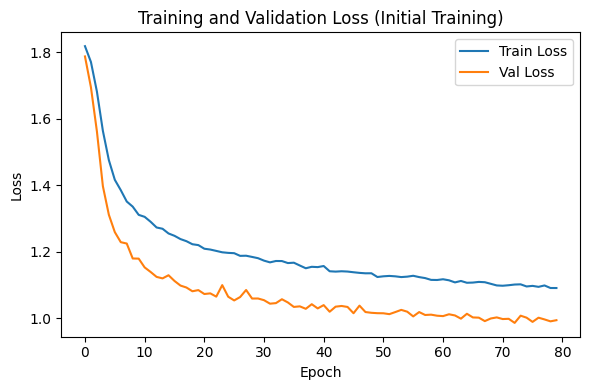

In [38]:
import matplotlib.pyplot as plt

# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (Initial Training)")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve_initial.png", dpi=300)
plt.show()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Initial Training)")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_initial.png", dpi=300)
plt.show()